# fast estimation of particle properties
Tim Tyree<br>
9.29.2021<br>
`conda activate pyenv_ub`

__GOALS__:
- DONE: compute dRdt versus 1/R for unconstrained random samples from smoothed and validated trajectories
- TODO: compute a from a bootstrap of 1/R versus a for one input_fn
- TODO: compute a from a bootstrap of 1/R versus a for one input_fn_lst
- TODO: compute a from a bootstrap of 1/R versus a for each input_fn_lst
- TODO: repeat for measuring ensemble MSD to give the diffusion coefficient, D
- TODO(later?): efficiently generate an _inline_ rendering of dRdt versus 1/R and MSD versus tau using dashly.  try the solution suggested on my stackoverflow post
- TODO: generate a .bluf for each input_fn_lst to document the particle property measurements
- TODO: show qualitative insenstivity to choice in navg1 and navg2

__TODO(later):__ bug mike to make certain that for the 99.95% accurate decoder, that the i^th neuron for the Match trials is the same as the i^th neuron for the Mismatch trials for all i neuron-units considered.

howdo hierarchical multi-indexing: https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html#hierarchical-indexing-multiindex

In [1]:
from lib.my_initialization import *
from lib import *
# from lib.measure.unwrap_and_smooth_cu import *
# from lib.rapids_func import *
# .routines.unwrap_and_smooth_trajectories_cu import *

import itertools
import dask_cudf
from lib.rapids_func import *
get_DT_cu

#magic    
%autocall 1
%load_ext autoreload
%autoreload 2

import cupy as cp, cudf, numba.cuda as cuda
import rmm
# Switch to RMM allocator
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

Automatic calling is: Smart


In [2]:
darkmode=True
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

# (optional) postprocess a token trajectory file
- Nota Bene: batch computation is already automated and optimized in 'fast postprocessing a list of trajectory folders.ipynb'

In [3]:
# input_fn=search_for_file()

# # #token FK at DT=0.4
# input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.2_traj_sr_400_mem_0.csv"

# # #tokenLR at DT=0.5
# input_fn=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/trajectories/ic002.31_traj_sr_600_mem_0.csv"
input_fn=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/trajectories/ic002.11_traj_sr_600_mem_0.csv"

#test routine on one file
testing=False
if testing:
    df=pd.read_csv(input_fn)
    DT=np.around(get_DT(df),5);print(f"DT={DT}")
    # ds=5 #cm
    # DS=ds/width
    tavg1=4 #moving average window, in ms
    width=200
    height=width
    use_drop_shorter_than=True
    drop_shorter_than=50 #ms
    tmin=100.#ms
    pid_col='particle'
    t_col='t'
    printing=False
    navg1=int(tavg1/DT)
    save_dir=return_moving_average_of_pbc_trajectories_and_save(
            input_fn, tavg1, pid_col, t_col, DT, width, height,
            use_drop_shorter_than, drop_shorter_than, tmin, printing)
    print(save_dir)

    df=load_smoothed_trajectories(save_dir,pid_col,t_col)
    df.head()

In [4]:
#run the routine on a whole folder
# print((DT, input_fn))
# save_dir_lst=routine_postprocess_trajectory_folder(input_fn,DT,tavg1=4, npartitions=None,
#                                         width=200,
#                                         height=200,
#                                         use_drop_shorter_than=True,
#                                         drop_shorter_than=50, #ms
#                                         tmin=100., #ms
#                                         pid_col='particle',
#                                         t_col='t',
#                                         printing=False)

In [5]:
# #TODO(later): compute squared displacements
# grouped=df.groupby(pid_col)
# #HINT: squared displacements of particles is result
#  throws AttributeError: DataFrameGroupBy object has no attribute first 
# result = (grouped[['x','y']]-grouped[['x','y']].first())**2

In [6]:
#TODO(later): implement a one_step method on an element in a finite element simulation
# HINT: cudf.Grouper?
# HINT: https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#grouping-with-a-grouper-specification
# HINT: https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#transformation

In [7]:
#DONE: figure out if there's an elegant was to use the cudf api  to do this
#for each group of event_id_int's :
#compare every particle to every other particle in a simple way
#compare every particle to every other particle to determine if the self,other pair intersects nontrivially

#DONE: determine condition for whether each pair is intersecting for at least two times 
# two particles exist for at least two times if both
#if other has a tmin > tmin of self
#AND if other has a tmax < tmax of self, 

# #DONE: construct the graph of all edges... this wasn't useful...
# G = cugraph.Graph()
# G.from_cudf_edgelist(df_pairs, source='src', destination='dst', edge_attr='dst')
# # # Let's now get the PageRank score of each vertex by calling cugraph.pagerank
# # df_page = cugraph.pagerank(G)
# # df_page.head()

In [8]:
#DONE: compute which edges are intersecting
#DONE: compute tmin and tmax for each intersecting edge
#DONE: compute duration for each intersecting edge
#DONE: sort edges by duration
#DONE: visualize the histogram of durations of intersecting edges
#DONE: consider a minimum_duration_threshold that is at least tavg2 if not specified

## scratchwerk

In [9]:
#DONT: figure out terrible numba debugging for a negligible speed boost
# @cuda.jit()#device=True)
# def distance_L2_pbc_cuda(point_1, point_2, dist_out, shape):
#     '''distance_L2_pbc_cu is a jit compiled function that 
#     returns for the euclidean (L2) distance between 
#     point_1 and point_2, which are in an N-cube of shape shape 
#     with periodic boundary conditions
    
#     Example Usage:
#     blockspergrid=1
#     threadsperblock=1
#     point_1=self_values[0]
#     point_2=other_values[0]
#     dist_out=0.#overwritten
#     shape=(width,height)
#     distance_L2_pbc_cuda[blockspergrid, threadsperblock](point_1, point_2, dist_out, shape)
#     '''
#     dq2 = 0.
#     for q1, q2, wid in zip(point_1, point_2, shape):
#         dq2 = dq2 + min(((q2 - q1)**2, (q2 + wid - q1 )**2, (q2 - wid - q1 )**2))
#     dist_out= dq2**0.5

# blockspergrid=1
# threadsperblock=1
# point_1=self_values[0]
# point_2=other_values[0]
# dist_out=np.array([0.])#*self_values
# shape=(width,height)
# # distance_L2_pbc_cuda(point_1, point_2, dist_out, shape)
# distance_L2_pbc_cuda[blockspergrid, threadsperblock](point_1, point_2, dist_out, shape)
# dist_out, point_1, point_2

# from numba import vectorize
# # shape=(width,height)
# # @vectorize(['float32[:](float32, float32, float32)'], target='cuda')
# shape=cp.array((width,height))
# @vectorize(['(float32[:,:], float32[:,:], float32[:,:], float32[:])'], target='cuda')
# def distance_L2_pbc_cu(self_values, other_values, dist_out_values, shape):
#     for point_1, point_2, dist_out in zip(self_values, other_values, dist_out_values):
#         distance_L2_pbc_cuda(point_1, point_2, dist_out, shape)

# # blockspergrid=1
# # threadsperblock=1
# dist_out_values=0.*self_values
# shape=cp.array((width,height))
# distance_L2_pbc_cu(self_values, other_values, dist_out_values, shape)
# # distance_L2_pbc_cuda[blockspergrid, threadsperblock](point_1, point_2, dist_out, shape)
# # dist_out

In [10]:
# def extract_xy_values_of_pair(df,pair,t_col='t'):
#     '''
#     df is a cudf.DataFrame instance of xy trajectories from no more than 1 trial 
#     pair is a row from a pandas.core.series.Series instance with columns,['pid_self', 'pid_other', 'tmin_self', 'tmin_other', 'tmax_self', 'tmax_other', 'tmin', 'tmax', 'duration', 'event_id_int']
    
#     Example Usage:
#     pair=pd.Series(df_pairs.head(1).to_pandas())
#     event_id_int=int(pair[trial_col])#.values.get())
#     dff=df[df[trial_col]==event_id_int]
#     self_values,other_values=extract_xy_values_of_pair(df=dff,pair=pair,t_col=t_col)
#     '''
#     dff=df
#     #DONE: optimize data retrieval from pair by using only one gpu-to-cpu memory transfer
#     pid_self =int(pair['pid_self'])#.values.get())
#     pid_other=int(pair['pid_other'])#.values.get())
#     tmin     =float(pair['tmin'])#.values.get())
#     tmax     =float(pair['tmax'])#.values.get())
#     #failed to broadcase in cudf
#     #     if event_id_int is not None:
#     #         dff=df[df[trial_col]==event_id_int]
#     #     else:
#     #         dff=df
#     df_self =dff.loc[(dff[pid_col]==pid_self),[t_col,'x','y']]
#     df_other=dff.loc[(dff[pid_col]==pid_other),[t_col,'x','y']]
#     self_values=df_self.loc[(df_self[t_col]>=tmin)&(df_self[t_col]<=tmax),['x','y']].values
#     other_values=df_other.loc[(df_other[t_col]>=tmin)&(df_other[t_col]<=tmax),['x','y']].values
#     return self_values,other_values

In [11]:
# pair=df_pairs.head(1)
# event_id_int=int(pair[trial_col].values.get())
# dff=df[df[trial_col]==event_id_int]
# self_values,other_values=extract_xy_values_of_pair(df=dff,pair=pair,t_col=t_col)
# print((self_values.shape,other_values.shape))
# assert ( self_values.shape==other_values.shape ) 

In [12]:
#this function may be slow and might not even work...
# def distance_L2_pbc_cu(self_values,other_values,shape):
#     '''distance_L2_pbc_cu is a jit compiled function that 
#     returns for the euclidean (L2) distance between 
#     point_1 and point_2, which are in an N-cube of shape shape 
#     with periodic boundary conditions
    
#     Example Usage:
#     shape=(width,height)
#     dist_values=distance_L2_pbc_cu(self_values,other_values,shape)
#     '''
#     sqdiff_values = (self_values-other_values)**2
#     #compute the other pbc options for sqdiff_values for each column
#     for n,w in enumerate(shape):
#         self_w_values  = self_values[:,n]
#         other_w_values = other_values[:,n]
#         sqdiff_w_values= sqdiff_values[:,n]
#         sqdiff_wp_values=(self_w_values-other_w_values-w)**2
#         sqdiff_wm_values=(self_w_values-other_w_values+w)**2
#         boop=sqdiff_wp_values<sqdiff_w_values
#         boom=sqdiff_wm_values<sqdiff_w_values
#         sqdiff_values[boop,n]=sqdiff_wp_values[boop]
#         sqdiff_values[boom,n]=sqdiff_wm_values[boom]

#     dist_values=cp.sqrt(cp.sum(sqdiff_values,axis=1))
#     return dist_values

In [13]:
#DONE: histograms sanity check df_intersecting_pairs
#DONE: verify that routine gives different values for different event_id_int
#DONE: wrap generation of df_intersecting_pairs into a function 
#DONE: include event_id_int outside ^that function
#DONE: accumulate df_intersecting_pairs_all over all event_id_int_values

# define module

In [14]:
# def comp_xy_distance_L2_pbc_cu(d,width,height):
#     '''comp_xy_distance_L2_pbc_cu is a pure cudf function that 
#     returns for the euclidean (L2) distance between 
#     point_1 and point_2, which are in a rectangular domain of shape (width,height) 
#     with periodic boundary conditions.
#     returns d with many fields added. the distance is dist.
#     supposes each row is uniquely indexed.
    
#     Example Usage:
#     df_traj=comp_xy_distance_L2_pbc_cu(df_traj,width,height)
#     '''
#     #compute the three options for the square distance with pbc
#     d['sdx']=(d['x_self']-d['x_other'])**2
#     d['sdxp']=(d['x_self']-d['x_other']+width)**2
#     d['sdxm']=(d['x_self']-d['x_other']-width)**2
#     d['sdy']=(d['y_self']-d['y_other'])**2
#     d['sdyp']=(d['y_self']-d['y_other']+height)**2
#     d['sdym']=(d['y_self']-d['y_other']-height)**2
#     #choose the minimum of each class of option
#     d['minsdx']=d[['sdx','sdxp','sdxm']].min(axis=1)
#     d['minsdy']=d[['sdy','sdyp','sdym']].min(axis=1)
#     d['dist']=(d['minsdx'] + d['minsdy'])**0.5
#     d['R']=d['dist']
#     return d

In [15]:
# def extract_trajectory_pairs_cu(df,df_pairs,pid_col,t_col,trial_col,col_lst=['index','x','y']):
#     '''supposes df contains trajectories with fields, col_lst, taken at time points, t_col, that are evently spaced by an amount that is inferred.
#     returns a cudf.DataFrame instance that has a column (for each col in col_lst) both for the self particle, indicated by pid_self, and for the other particle, indicated by pid_other.
#     Example Usage:
#     df_traj=extract_trajectory_pairs_cu(df,df_pairs,pid_col,t_col,trial_col)
#     '''
#     get_DT_cu(df,pid_col=pid_col,t_col=t_col)
#     df_pairs['num_rows']=((df_pairs['tmax']-df_pairs['tmin'])/DT).astype(cp.int32)

#     # df_pairs.reset_index(inplace=True)
#     super_index_values=np.repeat(df_pairs.index.values.get(),df_pairs['num_rows'].values.get())
#     df_traj=df_pairs.loc[super_index_values,[trial_col,'pid_self','pid_other']]
#     df_traj.reset_index(inplace=True)
#     df_traj.rename(columns={'index':'index_pairs'},inplace=True)

#     #compute time values for df_traj
#     num_row_values=df_pairs['num_rows'].values.get()
#     step_number_lsts=[list(range(num_rows)) for num_rows in num_row_values]
#     step_number_values=cp.hstack(step_number_lsts)
#     tmin_values=df_pairs.loc[super_index_values,'tmin']
#     t_values=cp.array(step_number_values*DT)+tmin_values
#     df_traj['t']=t_values.get()

#     #fill df_traj with the essential columns and an index pointing a particular row in df
#     index_col_lst=[trial_col,pid_col,t_col]
#     dff=df.set_index(index_col_lst)

#     #fill with self trajectories
#     df_traj.rename(columns={'pid_self':pid_col},inplace=True)
#     df_traj.set_index(index_col_lst,inplace=True)
    
#     dfff=dff.loc[df_traj.index]
#     for x in col_lst:
#         df_traj[x+'_self']=dfff[x]
#     df_traj=df_traj.reset_index().rename(columns={pid_col:'pid_self'}).rename(columns={'pid_other':pid_col})

#     #fill with other trajectories
#     df_traj.set_index(index_col_lst,inplace=True)
#     dfff=dff.loc[df_traj.index]
#     for x in col_lst:
#         df_traj[x+'_other']=dfff[x]
#     df_traj=df_traj.reset_index().rename(columns={pid_col:'pid_other'})
#     return df_traj

# compute the radial velocities with the savgol_filtered 

__Note:__ cugraph is a great tool for complex problems that happen in terms of graphs that benefit from visualization.  My graph problem is low-level, and therefore it does not appear beneficial for me to use cugraph here.

In [16]:
#define parameters
trial_col='event_id_int'
pid_col='particle' 
t_col='t' 
width=200
height=200
tmin=100.
printing=True
tavg1=4 #ms #moving average time window already performed
#TDOO: infer tavg1 from input_fn

In [17]:
ds=5. #cm for the whole domain
DS=ds/width #cm per pixel
tavg2=24 #ms #savgol_filter time window performed on R 

In [18]:
#decide on radial thresholds
minimum_range_threshold=0.1 #cm
maximum_range_threshold=1. #cm
minimum_duration_threshold=25 #ms

In [19]:
#TODO: figure out why I'm getting pid_self==pid_other in the R versus time plot...
#recall a couple postprocessed single trials
input_fn=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/smoothed_trajectories_navg_8/ic002.11_traj_sr_600_mem_0_smoothed.csv"
input_fn2=f"/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/smoothed_trajectories_navg_8/ic002.12_traj_sr_600_mem_0_smoothed.csv"
input_fn_lst=[input_fn,input_fn2]
# input_fn_lst=get_all_files_matching_pattern(input_fn,trgt='.csv')
print(f"loading {len(input_fn_lst)} files into shared memory...")
# df=dask_cudf.read_csv(input_fn_lst).compute()
df=cudf.read_csv(input_fn)
df=df.sort_values([trial_col,pid_col, t_col], ascending=True).copy()
DT=get_DT_cu(df,t_col,pid_col)
# navg2=int(tavg2/DT)
# if printing:
#     print(f"DT={DT} ms")    
navg2=int(tavg2/DT)
if not (navg2%2==1): #odd navg2 is required by savgol_filter
    navg2+=1
    tavg2=np.around(navg2*DT,7)
print(f'tavg2={tavg2}')
assert ( minimum_duration_threshold>tavg2)

loading 2 files into shared memory...
tavg2=24.5


In [20]:
#compute the intermediate dataframe of particle start/end times
grouped=df.groupby([trial_col,pid_col])
dft=grouped[t_col]
dfu=cudf.DataFrame({
    'tmin':dft.min(),
    'tmax':dft.max(),
})
dfu.reset_index(inplace=True)
# dff.head()

In [21]:
df_intersecting_pairs_all=identify_all_coexisting_pairs(df=dfu.copy(),pid_col=pid_col,t_col=t_col,trial_col=trial_col)
df_intersecting_pairs_all.head()

using 1 cores to identify pairs of particles that coexist over 1 independent trials...


,pid_self,pid_other,tmin_self,tmin_other,tmax_self,tmax_other,tmin,tmax,duration,event_id_int
0,1509,1519,3170.0,3239.5,3341.5,3341.5,3239.5,3341.5,102.0,1002116000
1,1509,1445,3170.0,3028.0,3341.5,3170.5,3170.0,3170.5,0.5,1002116000
2,1509,1538,3170.0,3317.5,3341.5,3379.5,3317.5,3341.5,24.0,1002116000
3,1509,1540,3170.0,3320.5,3341.5,3381.0,3320.5,3341.5,21.0,1002116000
4,1509,1511,3170.0,3175.5,3341.5,3274.0,3175.5,3274.0,98.5,1002116000


verified that the duration is strictly positive for all pairs of tips that coexist nontrivially


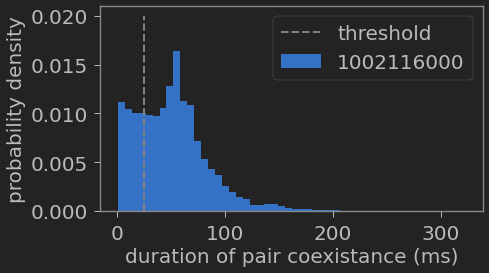

In [22]:
#test that duration is strictly positive
assert ( (df_intersecting_pairs_all['duration']>0).all() )
if printing:
    print (f"verified that the duration is strictly positive for all pairs of tips that coexist nontrivially")

#plot histogram of durations
fontsize=20
fig,ax=plt.subplots(figsize=(7,4))
yv=np.linspace(0,0.02,10)
ax.plot(minimum_duration_threshold+0.*yv,yv,'gray',lw=2, linestyle='dashed', label='threshold')
trial_col_lst=sorted(df_intersecting_pairs_all[trial_col].drop_duplicates().values.get())
for trial in trial_col_lst[:5]:
    df_intersecting_pairs_all.query(f"{trial_col} == {trial}")['duration'].to_pandas().hist(density=True,bins=50,ax=ax,label=trial,grid=False)#,color='event_id_int')
format_plot(ax, xlabel='duration of pair coexistance (ms)', ylabel='probability density', fontsize=fontsize, use_loglog=False)

ax.legend(fontsize=fontsize)
plt.tight_layout()
plt.show()

In [23]:
#DONE: verify that no pair points to the same spiral tip twice
assert ( not (df_intersecting_pairs_all['pid_self']==df_intersecting_pairs_all['pid_other']).any() )

In [24]:
grouped=df.groupby([trial_col,pid_col])
dft=grouped[t_col]
dfu=cudf.DataFrame({
    'tmin':dft.min(),
    'tmax':dft.max(),
})
dfu.reset_index(inplace=True)
df_intersecting_pairs_all=identify_all_coexisting_pairs(df=dfu.copy(),pid_col=pid_col,t_col=t_col,trial_col=trial_col)

#filter by duration_threshold
use_duration_threshold=True
if use_duration_threshold:
    df_pairs=df_intersecting_pairs_all[df_intersecting_pairs_all['duration']>minimum_duration_threshold]
else:
    df_pairs=df_intersecting_pairs_all
#and sort
df_pairs=df_pairs.sort_values([trial_col,'pid_self'], ascending=True).copy()
# trial_values=df[trial_col].drop_duplicates().values
# df_traj_lst=[]
# for trial in trial_values.get():
#     pass
# #     df_traj_lst.append(extract_trajectory_pairs_cu(df,df_pairs,pid_col=pid_col,t_col=t_col))
# # df_traj=cudf.concat(df_traj_lst)
# # df_traj.query('pid_self==25 and pid_other==25').head()

using 1 cores to identify pairs of particles that coexist over 1 independent trials...


In [25]:
df_traj=extract_trajectory_pairs_cu(df,df_pairs,pid_col,t_col,trial_col,DT)
#DONE: tested that index_self is never equal to index_other for a given event_id_int
#^this is equivalent to no two observations being the same
trial_values=df[trial_col].drop_duplicates().values
for trial in trial_values.get():
    d=df_traj.loc[df_traj[trial_col]==trial]
    assert ( not (d['index_other']==d['index_self']).any())

In [26]:
#compute the naive finite difference radial velocity between all pairs of particles
df_traj=comp_xy_distance_L2_pbc_cu(df_traj,width,height)
df_traj['R']=df_traj['dist']*DS #cm
#isolate only the columns relevant to computing the attraction coefficient, a
df_R=df_traj[[trial_col,'pid_self','pid_other',t_col,'R']].dropna()
df_R=df_R.sort_values([trial_col,'pid_self','pid_other',t_col], ascending=True).copy()
grouped=df_R.groupby([trial_col,'pid_self','pid_other'])
#compute the difference between two successive R values for each group
df_R['incol']=df_R['R']
mdwargs={'win_size':2}
result = grouped.apply_grouped(rolling_diff,
                               incols=['incol'],
                               outcols=dict(outcol=np.float64), kwargs=
                           mdwargs)
df_R['dRdt']=result['outcol']/DT*1000 #cm/s
df_R.drop(columns=['incol'],inplace=True)
#compute the average between two successive R values for each group
df_R['incol']=df_R['R']
mawargs={'win_size':2}
result = grouped.apply_grouped(rolling_avg,
                               incols=['incol'],
                               outcols=dict(outcol=np.float64), kwargs=
                           mawargs)
df_R['R_midpoint']=result['outcol'] #cm
df_R['one_over_R']=1./df_R['R_midpoint'] #1/cm
df_R.drop(columns=['incol'],inplace=True)
df_R.dropna(inplace=True)
df_R.head()

,event_id_int,pid_self,pid_other,t,R,dRdt,R_midpoint,one_over_R
386,1002116000,20,25,172.5,1.532008,15.909073,1.528031,0.654437
387,1002116000,20,25,173.0,1.539243,14.470294,1.535626,0.651200
388,1002116000,20,25,173.5,1.533510,-11.465892,1.536377,0.650882
389,1002116000,20,25,174.0,1.530391,-6.239646,1.531950,0.652763
390,1002116000,20,25,174.5,1.523670,-13.440887,1.527030,0.654866


In [27]:
#DONE: compute 1/R and dRdt_naive
#DONE: extract xy values for all particles lumped together
#TODO: verify visually that these values look reasonable
#TODO: compute the bootstrapped mean dRdt (y_values) binning by one_over_R (x_values)
R_values=df_R['R_midpoint'].values
x_values=df_R['one_over_R'].values
y_values=df_R['dRdt'].values

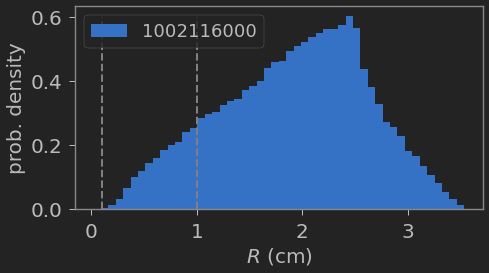

In [28]:
#plot histogram of durations
fontsize=20
fig,ax=plt.subplots(figsize=(7,4))

trial_col_lst=sorted(df_R[trial_col].drop_duplicates().values.get())
for trial in trial_col_lst[:5]:
    df_R.query(f"{trial_col} == {trial}")['R_midpoint'].to_pandas().hist(density=True,bins=50,ax=ax,label=trial,grid=False)#,color='event_id_int')
        
format_plot(ax, xlabel=r'$R$ (cm)', ylabel='prob. density', fontsize=fontsize, use_loglog=False)
ax.legend(fontsize=fontsize-2)

#plot threshold lines
yv=np.linspace(0,0.6,10)
ax.plot(minimum_range_threshold+0.*yv,yv,'gray',lw=2, linestyle='dashed', label='threshold')
ax.plot(maximum_range_threshold+0.*yv,yv,'gray',lw=2, linestyle='dashed', label='threshold')

plt.tight_layout()
plt.show()

In [29]:
xmin=-100
xmax=100

In [30]:
#DONE: plot a laplace distribution over ^this
xv=df_R.query(f"{trial_col} == {trial}")['dRdt'].values.get()
v=xv[(xv>xmin)&(xv<xmax)]
mu=np.mean(v)
beta=np.std(v)/np.sqrt(2)
def comp_laplace_pdf(x,mu,beta):
    return np.exp(-np.abs(x-mu)/beta)/(2*beta)

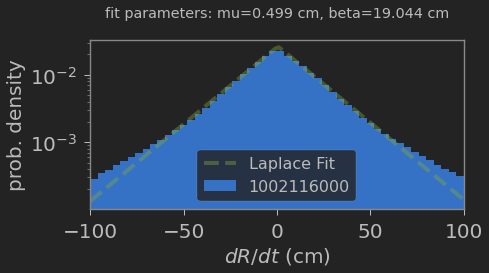

In [31]:
#plot histogram of durations
fontsize=20
fig,ax=plt.subplots(figsize=(7,4))
trial_col_lst=sorted(df_R[trial_col].drop_duplicates().values.get())
for trial in trial_col_lst[:5]:
    xv=df_R.query(f"{trial_col} == {trial}")['dRdt'].values.get()
    v=xv[(xv>xmin)&(xv<xmax)]# np.max(xv),np.quantile(xv,.15),np.mean(xv),np.quantile(xv,.85),np.max(xv)
    ax.hist(v,density=True,bins=50,label=trial)#,grid=False)#,color='event_id_int')
#     ax.hist(v,density=True,bins='auto',label=trial)#,grid=False)#,color='event_id_int')
 

#plot the max likelihood fit to the laplace distribution
x_values=np.linspace(xmin,xmax,100)
laplace_values=comp_laplace_pdf(x_values,mu,beta)
plt.plot(x_values,laplace_values,'g--',lw=4,alpha=0.4,label='Laplace Fit')

format_plot(ax, xlabel=r'$dR/dt$ (cm)', ylabel='prob. density', fontsize=fontsize, use_loglog=False)
ax.legend(fontsize=fontsize-4,loc='lower center')
ax.set_yscale('log')
ax.set_xlim([xmin,xmax])
ax.set_title(f'fit parameters: mu={mu:.3f} cm, beta={beta:.3f} cm\n')
# ax.set_ylim([0,0.01])
plt.tight_layout()
plt.show()

In [32]:
#index by individual pairs
dfr=df_R.set_index([trial_col,'pid_self','pid_other']).sort_values(by='t')
#identify all pairs that are within this range
boo=(dfr['R']<=maximum_range_threshold)&(dfr['R']>=minimum_range_threshold)
index_values=dfr.index.drop_duplicates().values

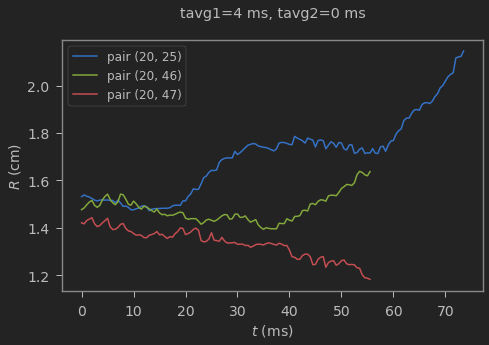

In [33]:
#plot a few particle events
fontsize=14
fig,ax=plt.subplots(figsize=(7,5))
for iv in index_values.get()[:3]:
    x_values,y_values=dfr.loc[iv].sort_values(by='t')[['t','R']].values.T.get()
    ax.plot(x_values-x_values[0],y_values,label=f"pair {(iv[1],iv[2])}")
format_plot(ax, xlabel=r'$t$ (ms)', ylabel=r'$R$ (cm)', fontsize=fontsize, use_loglog=False)
ax.legend(fontsize=fontsize-2)
plt.title(f'tavg1={tavg1} ms, tavg2={0} ms\n')
plt.tight_layout()
plt.show()

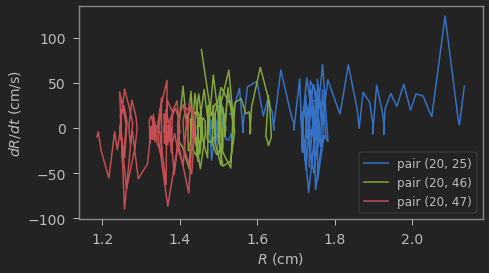

In [34]:
#plot a few particle events
fontsize=14
fig,ax=plt.subplots(figsize=(7,4))
for iv in index_values.get()[:3]:
    x_values,y_values=dfr.loc[iv].sort_values(by='t')[['R_midpoint','dRdt']].values.T.get()
#     ax.scatter(x_values,y_values,label=f"pair {(iv[1],iv[2])}")
    ax.plot(x_values,y_values,label=f"pair {(iv[1],iv[2])}")
format_plot(ax, xlabel=r'$R$ (cm)', ylabel=r'$dR/dt$ (cm/s)', fontsize=fontsize, use_loglog=False)
ax.legend(fontsize=fontsize-2)
plt.tight_layout()
plt.show()

# compute the radial velocities with the savgol_filtered 

In [35]:
savgol_kwargs=dict(
    window_length=navg2,
    polyorder=3,
    deriv=1,
    delta=1.0,
    axis=-1,
    mode='interp'
)

savgol0_kwargs=dict(
    window_length=navg2,
    polyorder=3,
    deriv=0,
    delta=1.0,
    axis=-1,
    mode='interp'
)

df_traj=extract_trajectory_pairs_cu(df,df_pairs,pid_col,t_col,trial_col,DT)
#compute the naive finite difference radial velocity between all pairs of particles
df_traj=comp_xy_distance_L2_pbc_cu(df_traj,width,height)
df_traj['R']=df_traj['dist']*DS #cm
#isolate only the columns relevant to computing the attraction coefficient, a
df_R=df_traj[[trial_col,'pid_self','pid_other',t_col,'R']].dropna()
df_R=df_R.sort_values([trial_col,'pid_self','pid_other',t_col], ascending=True)#.copy()

#compute the smoothed derivative savgol_filter using scipy's cryptic cython code
grouped=df_R.to_pandas().groupby([trial_col,'pid_self','pid_other'])
result = grouped['R'].apply(savgol_filter,**savgol_kwargs)
dRdt_values=cp.array(np.concatenate(result.values))
df_R['dRdt']=dRdt_values

#compute the smoothed value savgol_filter using scipy's cryptic cython code
grouped=df_R.to_pandas().groupby([trial_col,'pid_self','pid_other'])
result = grouped['R'].apply(savgol_filter,**savgol0_kwargs)
R_values=cp.array(np.concatenate(result.values))
df_R['R']=R_values

df_R['one_over_R']=1./df_R['R'] #1/cm
df_R.dropna(inplace=True)
df_R.head()

#index by individual pairs
dfr=df_R.set_index([trial_col,'pid_self','pid_other']).sort_values(by='t')
#identify all pairs that are within this range
boo=(dfr['R']<=maximum_range_threshold
    )&(dfr['R']>=minimum_range_threshold)
index_values=boo.index.drop_duplicates().values

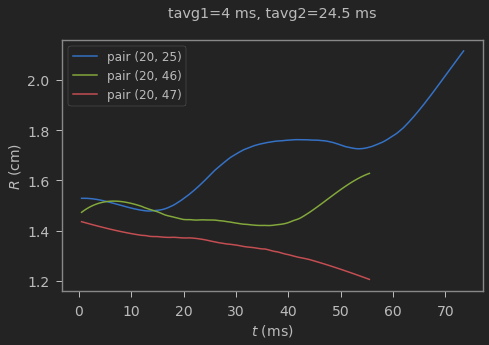

In [36]:
#plot a few particle events
fontsize=14
fig,ax=plt.subplots(figsize=(7,5))
for iv in index_values.get()[:3]:
#     x_values,y_values=dfr2.loc[iv][['t','R']].values.T.get()
    x_values,y_values=dfr.loc[iv][['t','R']].sort_values(by='t').values.T.get()
    x_values=(x_values-x_values[0])[1:-1]
    y_values=y_values[1:-1]
    ax.plot(x_values,y_values,label=f"pair {(iv[1],iv[2])}")
format_plot(ax, xlabel=r'$t$ (ms)', ylabel=r'$R$ (cm)', fontsize=fontsize, use_loglog=False)
ax.legend(fontsize=fontsize-2)
plt.title(f'tavg1={tavg1} ms, tavg2={tavg2} ms\n')
plt.tight_layout()
plt.show()

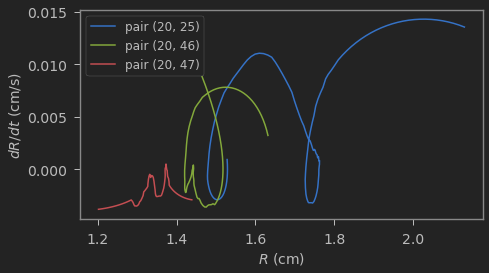

In [37]:
#plot a few particle events
fontsize=14
fig,ax=plt.subplots(figsize=(7,4))
for iv in index_values.get()[:3]:
    x_values,y_values=dfr.loc[iv].sort_values(by='t')[['R','dRdt']].values.T.get()
    x_values=x_values#[4:]
    y_values=y_values#[4:]
    ax.plot(x_values,y_values,label=f"pair {(iv[1],iv[2])}")
format_plot(ax, xlabel=r'$R$ (cm)', ylabel=r'$dR/dt$ (cm/s)', fontsize=fontsize, use_loglog=False)
ax.legend(fontsize=fontsize-2)
plt.tight_layout()
plt.show()

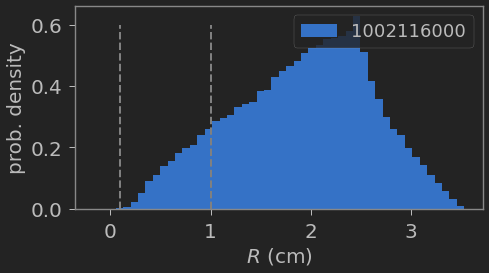

In [50]:
#plot histogram of durations
fontsize=20
fig,ax=plt.subplots(figsize=(7,4))

trial_col_lst=sorted(df_R[trial_col].drop_duplicates().values.get())
for trial in trial_col_lst[:5]:
    df_R.query(f"{trial_col} == {trial}")['R'].to_pandas().hist(density=True,bins=50,ax=ax,label=trial,grid=False)#,color='event_id_int')
        
format_plot(ax, xlabel=r'$R$ (cm)', ylabel='prob. density', fontsize=fontsize, use_loglog=False)
ax.legend(fontsize=fontsize-2)

#plot threshold lines
yv=np.linspace(0,0.6,10)
ax.plot(minimum_range_threshold+0.*yv,yv,'gray',lw=2, linestyle='dashed', label='threshold')
ax.plot(maximum_range_threshold+0.*yv,yv,'gray',lw=2, linestyle='dashed', label='threshold')

plt.tight_layout()
plt.show()

In [48]:
xmin=-1;xmax=1
#DONE: plot a laplace distribution over ^this
xv=df_R.query(f"{trial_col} == {trial}")['dRdt'].values.get()
v=xv[(xv>xmin)&(xv<xmax)]
mu=np.mean(v)
beta=np.std(v)/np.sqrt(2)
def comp_laplace_pdf(x,mu,beta):
    return np.exp(-np.abs(x-mu)/beta)/(2*beta)

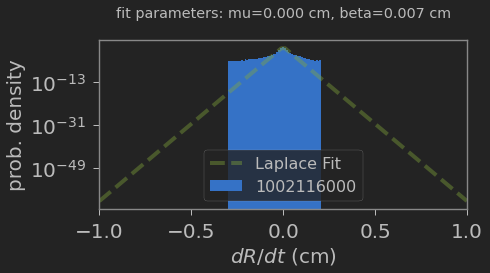

In [49]:
#plot histogram of durations
fontsize=20
fig,ax=plt.subplots(figsize=(7,4))
trial_col_lst=sorted(df_R[trial_col].drop_duplicates().values.get())
for trial in trial_col_lst[:5]:
    xv=df_R.query(f"{trial_col} == {trial}")['dRdt'].values.get()
    v=xv[(xv>xmin)&(xv<xmax)]# np.max(xv),np.quantile(xv,.15),np.mean(xv),np.quantile(xv,.85),np.max(xv)
    ax.hist(v,density=True,bins=50,label=trial)#,grid=False)#,color='event_id_int')
#     ax.hist(v,density=True,bins='auto',label=trial)#,grid=False)#,color='event_id_int')
 

#plot the max likelihood fit to the laplace distribution
x_values=np.linspace(xmin,xmax,100)
laplace_values=comp_laplace_pdf(x_values,mu,beta)
plt.plot(x_values,laplace_values,'g--',lw=4,alpha=0.4,label='Laplace Fit')

format_plot(ax, xlabel=r'$dR/dt$ (cm)', ylabel='prob. density', fontsize=fontsize, use_loglog=False)
ax.legend(fontsize=fontsize-4,loc='lower center')
ax.set_yscale('log')
ax.set_xlim([xmin,xmax])
ax.set_title(f'fit parameters: mu={mu:.3f} cm, beta={beta:.3f} cm\n')
# ax.set_ylim([0,0.01])
plt.tight_layout()
plt.show()

In [41]:
# #THIS IS THE SHORTEST PATH TO Success
# MULTIINDEX SO THE PRIMITIVE OBJECT IS THE RANGE TIME SERIES
# COMPUTE KEY VALUES 1/R AND DRDT
# NAIVELY MEASURE A
# REMOVE OUTLIER A VALUES OR A THAT RECIEVED A NASTY FIT
# RECOMPUTE A WITH AN ENSEMBLE BOOTSTRAP
# IF A IS STILL NOT GREAT, CONSIDER USINVE TAVG2 WITH SOMETHING LIKE A SAVGOL FILTER IMPLEMENTED AS AN FIR FILTER
# KEEP TRYING UNTIL I HAVE AN ESTIMATE OF A THAT IS CONSISTENT WITH THE PARTICLE MODEL

In [42]:
# #THIS IS THE SHORTEST PATH TO Success
# df.loc[[0,0]]
# #can I repeat a label? using loc. yes!  THIS CAN BE SOLVE SIMPLY BY 
# # USE DF_PAIRS TO DETERMINE THE MULTIPLICITY_self OF EACH PID_SELF
# multiplicity_self=df_pairs.groupby([trial_col,'pid_self'])['tmin'].count()
# # # USE DF_PAIRS TO DETERMINE THE MULTIPLICITY_other OF EACH PID_OTHER
# # SET THE INDEX TO PID_COL IN DF AS DFP
# dfp=df.set_index(pid_col)
# # MAKE A LIST OF INDICIES WHERE PID_COL IS REPEATED MULTIPLICITY TIMES

# # LOCATE AND COPY DF WITH ^THAT LIST FOR SELF
# # MAKE A LIST OF INDICIES WHERE PID_COL IS REPEATED MULTIPLICITY TIMES
# # LOCATE AND COPY DF WITH ^THAT LIST FOR OTHER
# # MAKE A SINGLE DF WITH ALL OF THE DESIRED COLUMNS (SEE HANDWRITTEN (3))
# # REWRITE A PANDASESQUE DIST_L2_PBC_CUDF MEASURE 
# # COMPUTE THE CUDF DATAFRAME OF ALL RANGE TIMESERIES FOR ALL PAIRS

In [43]:
# #DONE: visually verify these values look sensible
# plt.plot(dist_values.get())
# plt.show()
# plt.plot(self_values[:,0].get(),self_values[:,1].get())
# plt.plot(other_values[:,0].get(),other_values[:,1].get())
# plt.show()

In [44]:
# #DONE:compute the distance in x between any points where two spiral tips occur at the same time in t
# #is the best way to do this to project to cupy and to run all rows in  together in a daskbag?  sure.

# next step: get a reasonable value for the attraction coefficient, a

In [ ]:
#TODO: bootstrap dRdt versus R for one input_fn
#TODO: compute a for one input_fn

#TODO: copy all ^this into 1 function and test it on two input_fn_lsts 
#TODO: apply ^that to a daskbag routine mapping each input_fn in input_fn_lst to a df_traj
#TODO: merge df_traj_lst to df_traj_all and save to csv
#TODO: bootstrap dRdt versus R for input_fn_kst
#TODO: compute a for one input_fn_lst

In [45]:
#TODO(IMMEDIATE FOLLOWUP GOAL): show how insensitive a is to choice in navg1 (and/or navg2 if I'm using it!)
#GOAL_QUESTION: does there exist a tavg1 that produces the right expected a for a single termination event??

In [46]:
#TODO: estimate an ensemble averaged a estimate
#TODO: augment df_interacting_pairs with estimates for a for individual pairs of particles
#TODO: use ^that to filter based on Rsq or Delta_a and recompute an ensemble averaged a estimate

In [47]:
print(f"hooray!")

hooray!
